# Neuron Model Analysis

**Contents**:

- [What's done in BrainPy](#What's-done-in-BrainPy)
- [Phase Plane Analysis](#Phase-Plane-Analysis)
- [Bifurcation Analysis](#Bifurcation-Analysis)
- [Fast-Slow System Bifurcation](#Fast-Slow-System-Bifurcation)

In addition to the flexible and effecient *neurodynamics simulation*, another ambition of BrainPy is to provide an integrative platform for **neurodynamics analysis**.

As is known to us all, dynamics analysis is necessary in neurodynamics. This is because blind simulation of nonlinear systems is likely to produce few results or misleading results. For example, attractors and repellors can be easily obtained through simulation by time forward and backward, while saddles can be hard to find. 

Currently, BrainPy supports neurodynamics analysis for low-dimensional neuron models. Specifically, BrainPy provides the following methods for neuron model analysis:

1. phase plane analysis for one-dimensional and two-dimensional systems;
2. codimension one and codimension two bifurcation analysis;
3. bifurcation analysis of the fast-slow system. 


In this section, I will illustrate how to do neuron dynamics analysis in BrainPy and how BrainPy implements it.

In [1]:
import brainpy as bp
import numpy as np

## What's done in BrainPy

The neuron model analysis is implemented in `brainpy.analysis`. It is used to analyze the phase portrait and bifurcation mechanism of 1D or 2D dynamical systems. It can also be used to analyze the high-dimensional system but with the fixation of other variables to preserve only one or two dynamical variables.

For a given two-dimensional system

$$
{dx \over dt} = f(x, t, y) \\
{dy \over dt} = g(y, t, x),
$$

once users code the system with the format of BrainPy, like

In [2]:
@bp.integrate
def int_x(x, t, y, p1):
    f = 1.
    return f

@bp.integrate
def int_y(y, t, x, p2):
    g = 1.
    return g

def update(ST, _t):
    ST['x'] = int_x(ST['x'], _t, ST['y'], ST['p1'])
    ST['y'] = int_y(ST['y'], _t, ST['x'], ST['p2'])

example = bp.NeuType('example', steps=update, ST=bp.NeuState('x', 'y', 'p1', 'p2'))

BrainPy will immediately know what integrators have you defined in the model. 

In [3]:
example.integrators

For each integrator, the user-defined variable name and its time variable name will be parsed out.

In [4]:
example.integrators[0].diff_eq.var_name, example.integrators[1].diff_eq.var_name

('x', 'y')

In [5]:
example.integrators[0].diff_eq.t_name, example.integrators[1].diff_eq.t_name

('t', 't')

Their dependence between each other will also be resolved.

In [6]:
example.integrators[0].diff_eq.func_args, example.integrators[1].diff_eq.func_args

(['x', 't', 'y', 'p1'], ['y', 't', 'x', 'p2'])

By using these informations and the function contents, it is easy to tranform the user-defined differential functions to expressions which are compatible with the computer algebra system (such as SymPy). 

Therefore, for a two-dimensional dynamical system, its phase plane and bifurcation analysis will follow the following steps:

1. Use abstract syntax tree (AST) to parse the mathematical expressions defined by the user codes. And then convert them into expressions which are compatible with SymPy.
2. Try to solve $f(x, y)=0$ to get the dependece of $x = f_1(y)$ by using SymPy. 
  - If success, substitute $x = f_1(y)$ into $g(x, y) = 0$; then use the iterative method to find the function root $\hat{y}$, and get $\hat{x} = f_1(\hat{y})$; go to step 5. 
  - If failed, try to solve $f(x, y) = 0$ to get the dependence of $y=f_2(x)$. 
      - If sucess, substitute $y = f_2(x)$ into $g(x, y) = 0$; then use the iterative method to find the function root $\hat{x}$, and get $\hat{y} = f_2(\hat{x})$; go to step 5.
      - If failed, go to step 3.
3. Try to solve $g(x, y)=0$ to get the dependece of $x = g_1(y)$. 
  - If success, substitute $x = g_1(y)$ into $f(x, y) = 0$; then use the iterative method to find the function root $\hat{y}$, and get $\hat{x} = g_1(\hat{y})$; go to step 5. 
  - If failed, try to solve $g(x, y) = 0$ to get the dependence of $y=g_2(x)$. 
      - If sucess, substitute $y = g_2(x)$ into $f(x, y) = 0$; then use the iterative method to find the function root $\hat{x}$, and get $\hat{y} = g_2(\hat{x})$; go to step 5.
      - If failed, go to step 4.
4. Contruct a non-zero optimization function $h(x,y) = f^2(x,y) + g^2(x, y)$; use a gradient descent method to find all the minimum points in the whole space; For each minimum point $(\bar{x}, \bar{y})$, check whether the value of the optimization function $h(\bar{x}, \bar{y})$ is less than $10^{-8}$; If so, the point is the fixed point $h(\hat{x}, \hat{y})$ of the equation; go to step 5.
5. Make a small perturbation $\delta$ at each fixed point $(\hat{x}, \hat{y})$, get the Jacobian matrix and judge its stability:
$$
\left(\begin{array}{ll}
{f(\hat{x} + \delta, \hat{y}) - f(\hat{x}, \hat{y}) \over \delta} & 
{f(\hat{x}, \hat{y}+ \delta) - f(\hat{x}, \hat{y}) \over \delta} \\
{g(\hat{x} + \delta, \hat{y}) - g(\hat{x}, \hat{y}) \over \delta} & 
{g(\hat{x}, \hat{y}+ \delta) - g(\hat{x}, \hat{y}) \over \delta}
\end{array}\right).
$$ 


The bifurcation analysis is very similar to the phase plane analysis. What different is for each function $f(x, y)$, the parameter $p_1, p_2$ are inclued $f(x, y, p_1, p_2)$. 

## Phase Plane Analysis

Here, I will illustrate how to do phase plane analysis by using a well-known neuron model FitzHugh-Nagumo model.

**FitzHugh-Nagumo model**

The FitzHugh-Nagumo model is given by:

$$ 
\frac {dV} {dt} = V(1 - \frac {V^2} 3) - w + I_{ext} \\
\tau \frac {dw} {dt} = V + a - b w 
$$

There are two variables $V$ and $w$, so this is a two-dimensional system with three parameters $a, b$ and $\tau$.

In [7]:
bp.profile.set(dt=0.02, numerical_method='rk4')  # will be useful in "plot_trajectory()"


a=0.7; b=0.8; tau=12.5; Vth=1.9

@bp.integrate
def int_w(w, t, v):
    return (v + a - b * w) / tau

@bp.integrate
def int_v(v, t, w, Iext):
    return v - v * v * v / 3 - w + Iext

def update(ST, _t):
    ST['w'] = int_w(ST['w'], _t, ST['v'])
    v = int_v(ST['v'], _t, ST['w'], ST['input'])
    ST['spike'] = np.logical_and(v >= Vth, ST['v'] < Vth)
    ST['v'] = v
    ST['input'] = 0.

state = bp.types.NeuState('v', 'w', 'spike', 'input')

FN = bp.NeuType(name='FN', ST=state, steps=update)

Phase Plane Analysis is implemented in `brainpy.analysis.PhasePlane`. It receives the following parameters: 

- ``model``: The neuron model to be analysis. It must be an instance of `brainpy.NeuType`.
- ``target_vars``: The variables to be analuzed. It must a dictionary with the format of `{var: variable range}`.
- ``fixed_vars``: The variables to be fixed (optional).
- ``pars_update``: Parameters to update (optional).

`brainpy.analysis.PhasePlane` provides interface to analyze the system's 

- **nullcline**: The zero-growth isoclines, such as $g(x, y)=0$ and $g(x, y)=0$.
- **fixed points**: The equilibrium points of the system, which are located at all of the nullclines intersect.
- **vector filed**: The vector field of the system.
- **Trajectory**: A given simulation trajectory with the fixed variables.

Here we perform a phase plane analysis with parameters $a=0.7, b=0.8, \tau=12.5$, and input $I_{ext} = 0.8$.

SymPy solve "int_w(v, w) = 0" to "w = f(v, )", success.
SymPy solve "int_v(v, w) = 0" to "w = f(v, )", success.
SymPy solve derivative of "int_v(v, w)" by "v", success.
SymPy solve derivative of "int_v(v, w)" by "w", success.
SymPy solve derivative of "int_w(v, w)" by "v", success.
SymPy solve derivative of "int_w(v, w)" by "w", success.
Fixed point #1 at v=-0.2729009589972752, w=0.5338738012534059 is a unstable-node.


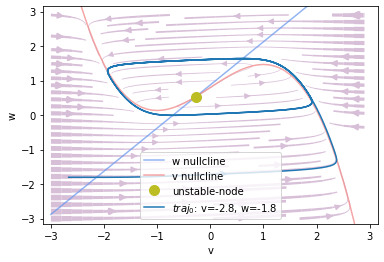

In [8]:
analyzer = bp.analysis.PhasePlane(
    model=FN,
    target_vars={'v': [-3, 3], 'w': [-3., 3.]},
    fixed_vars={'Iext': 0.8, 'input': 0.8})
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'v': -2.8, 'w': -1.8}],
                         duration=100.,
                         show=True)

We can see an unstable-node at the point (v=-0.27, w=0.53) inside a limit cycle. Then we can run a simulation with the same parameters and initial values to see the periodic activity that correspond to the limit cycle.

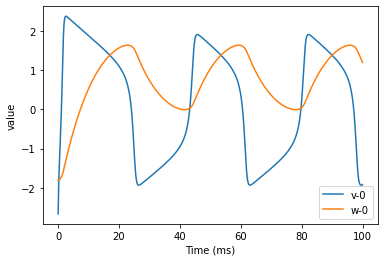

In [9]:
group = bp.NeuGroup(FN, 1, monitors=['v', 'w'])
group.ST['v'] = -2.8
group.ST['w'] = -1.8
group.run(100., inputs=('ST.input', 0.8)) 
bp.visualize.line_plot(group.mon.ts, group.mon.v, legend='v', ) 
bp.visualize.line_plot(group.mon.ts, group.mon.w, legend='w', show=True)

Note that the `fixed_vars` can be used to specify the neuron model's state `ST`, it can also be used to specify the functional arguments in integrators (like the `Iext` in `int_v()`). 

## Bifurcation Analysis

Bifurcation analysis is implemented within `brainpy.analysis.Bifurcation`. Which support codimension-1 and codimension-2 bifurcation analysis. Specifically, it receives the following parameter settings: 

- ``model``: The neuron model to be analyed. Must be an instance of `brainpy.NeuType`.
- ``target_pars``: The target parameters. Must be a dictionary with the format of `{par: parameter range}`. 
- ``target_vars``: The target variables. Must be a dictionary with the format of `{var: variable range}`. 
- ``fixed_vars``: The fixed variables.
- ``pars_update``: The parameters to update.

**Codimension 1 bifurcation analysis**

We will first see the codimension 1 bifurcation anlysis of the model. For example, we vary the input $I_{ext}$ between 0 to 1 and see how the system change it's stability.

SymPy solve "int_w(v, w, Iext) = 0" to "w = f(v, Iext)", success.
SymPy solve derivative of "int_v(v, w, Iext)" by "v", success.
SymPy solve derivative of "int_v(v, w, Iext)" by "w", success.
SymPy solve derivative of "int_w(v, w, Iext)" by "v", success.
SymPy solve derivative of "int_w(v, w, Iext)" by "w", success.


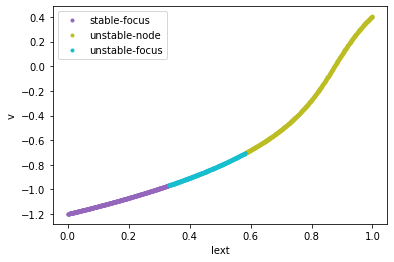

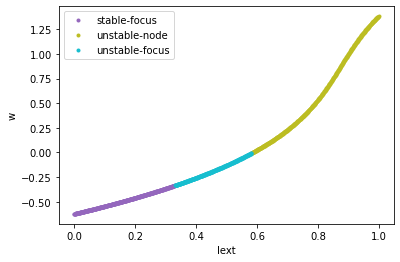

In [10]:
analyzer = bp.analysis.Bifurcation(
    model=FN,
    target_pars={'Iext': [0., 1.]},
    target_vars={'v': [-3, 3], 'w': [-3., 3.]},
    numerical_resolution=0.001,
)
analyzer.plot_bifurcation(show=True)

**Codimension 2 bifurcation analysis**

We simulaneously change $I_{ext}$ and parameter $a$.

SymPy solve "int_w(v, w, a, Iext) = 0" to "w = f(v, a,Iext)", success.
SymPy solve derivative of "int_v(v, w, a, Iext)" by "v", success.
SymPy solve derivative of "int_v(v, w, a, Iext)" by "w", success.
SymPy solve derivative of "int_w(v, w, a, Iext)" by "v", success.
SymPy solve derivative of "int_w(v, w, a, Iext)" by "w", success.


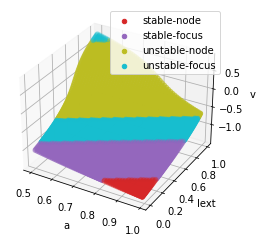

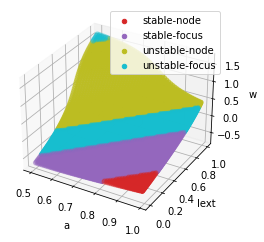

In [14]:
from collections import OrderedDict

analyzer = bp.analysis.Bifurcation(
    model=FN,
    target_pars=OrderedDict(a=[0.5, 1.], Iext=[0., 1.]),
    target_vars=OrderedDict(v=[-3, 3], w=[-3., 3.]),
    numerical_resolution=0.01,
)
analyzer.plot_bifurcation(show=True)

## Fast-Slow System Bifurcation

BrainPy also provides a tool for fast-slow system bifurcation analysis by using `brainpy.analysis.FastSlowBifurcation`. This method is proposed by John Rinzel [1, 2, 3]. (J Rinzel, 1985, 1986, 1987) proposed that in a fast-slow dynamical system, we can treat the slow variables as the bifurcation parameters, and then study how the different value of slow variables affect the bifurcation of the fast sub-system.


`brainpy.analysis.FastSlowBifurcation` is very usefull in the bursting neuron analysis. I will illustrate this by using the Hindmarsh-Rose model. The Hindmarsh–Rose model of neuronal activity is aimed to study the spiking-bursting behavior of the membrane potential observed in experiments made with a single neuron. Its dynamics are governed by:

$$
\frac{d V}{d t} = y - a V^3 + b V^2 - z + I\\
\frac{d y}{d t} = c - d V^2 - y\\
\frac{d z}{d t} = r (s (V - V_{rest}) - z)
$$






First of all, let's define the Hindmarsh–Rose model with BrainPy. 

In [17]:
bp.profile.set(dt=0.02, numerical_method='rk4')

a = 1.; b = 3.; c = 1.; d = 5.; s = 4. 
x_r = -1.6; r = 0.001; Vth = 1.9

state = bp.types.NeuState('x', 'y', 'z', 'spike', 'input')

@bp.integrate
def int_x(x, t, y, z, Isyn):
    return y - a * x ** 3 + b * x * x - z + Isyn

@bp.integrate
def int_y(y, t, x):
    return c - d * x * x - y

@bp.integrate
def int_z(z, t, x):
    return r * (s * (x - x_r) - z)

def update(ST, _t):
    ST['y'] = int_y(ST['y'], _t, ST['x'])
    ST['z'] = int_z(ST['z'], _t, ST['x'])
    x = int_x(ST['x'], _t, ST['y'], ST['z'], ST['input'])
    ST['spike'] = np.logical_and(x >= Vth, ST['x'] < Vth)
    ST['x'] = x
    ST['input'] = 0.


neuron = bp.NeuType(name='Hindmarsh_Rose_model',
                    ST=state, steps=update)

We now can start to analysis the underlying bifurcation mechanism.

SymPy solve "int_y(x, y, z) = 0" to "y = f(x, z)", success.
SymPy solve derivative of "int_x(x, y, z)" by "x", success.
SymPy solve derivative of "int_x(x, y, z)" by "y", success.
SymPy solve derivative of "int_y(x, y, z)" by "x", success.
SymPy solve derivative of "int_y(x, y, z)" by "y", success.


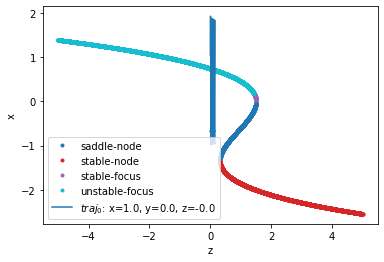

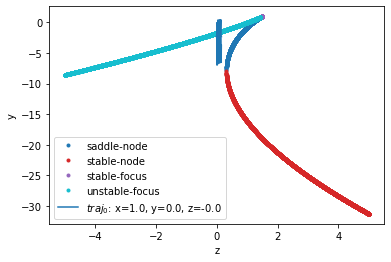

In [18]:
analyzer = bp.analysis.FastSlowBifurcation(
    model=neuron,
    fast_vars={'x': [-3, 3], 'y': [-10., 5.]},
    slow_vars={'z': [-5., 5.]},
    fixed_vars={'Isyn': 0.5, 'input': 0.5, },
    numerical_resolution=0.001
)
analyzer.plot_bifurcation()
analyzer.plot_trajectory([{'x': 1., 'y': 0., 'z': -0.0}],
                         duration=30.,
                         show=True)

**References**:

[1] Rinzel, John. "Bursting oscillations in an excitable membrane model." In Ordinary and partial differential  equations, pp. 304-316. Springer, Berlin, Heidelberg, 1985.
           
[2] Rinzel, John , and Y. S. Lee . On Different Mechanisms for Membrane Potential Bursting. Nonlinear Oscillations in Biology and Chemistry. Springer Berlin Heidelberg, 1986.

[3] Rinzel, John. "A formal classification of bursting mechanisms in excitable systems." In Mathematical topics in population biology, morphogenesis and neurosciences, pp. 267-281. Springer, Berlin, Heidelberg, 1987.


**Outlook**

In future, we will provide more analysis methods for various dynamical systems. We now also start to consider how to analyze the network model. Of course, we welcome your contributions on neurodynamics analysis. 